<a href="https://colab.research.google.com/github/Moin000/Certification/blob/master/A_B_Test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
from matplotlib import rcParams
from pathlib import Path
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

data = pd.read_csv("/content/referral.csv")
print(data.head())
data.date = pd.to_datetime(data.date)


   user_id        date country  money_spent  is_referral      device_id
0        2  2015-10-03      FR           65            0  EVDCJTZMVMJDG
1        3  2015-10-03      CA           54            0  WUBZFTVKXGQQX
2        6  2015-10-03      FR           35            0  CBAPCJRTFNUJG
3        7  2015-10-03      UK           73            0  PRGXJZAJKMXRH
4        7  2015-10-03      MX           35            0  PRGXJZAJKMXRH


In [4]:
print(data.isnull().sum())

user_id        0
date           0
country        0
money_spent    0
is_referral    0
device_id      0
dtype: int64


In [5]:
print(data[['is_referral','money_spent']].groupby(['is_referral']).count())

             money_spent
is_referral             
0                  69324
1                  28017


In [6]:
#Let’s check data reliability. Firstly, the referral program started on Oct, 31. Let’s make sure we have no referred users prior to that:
print(data[data['is_referral']==1]['date'].min())

2015-10-31 00:00:00


In [7]:
print(data.query('date<\'2015-10-31\'')['is_referral'].value_counts())

is_referral
0    47341
Name: count, dtype: int64


In [8]:
##what about after?
print(data.query('date>\'2015-10-30\'')['is_referral'].value_counts())

is_referral
1    28017
0    21983
Name: count, dtype: int64


In [9]:
#Each user then should not be in both groups. Let’s see
print(data.groupby('user_id').is_referral.nunique().sort_values(ascending=False).head(5))


user_id
9776     2
6639     2
13642    2
6661     2
6660     2
Name: is_referral, dtype: int64


In [10]:
print(data.query('user_id==9776'))

       user_id       date country  money_spent  is_referral      device_id
61364     9776 2015-11-07      CA           53            0  UWKROJTCYNTHF
61365     9776 2015-11-07      CA           15            1  UWKROJTCYNTHF
94319     9776 2015-11-25      ES           20            0  UWKROJTCYNTHF


In [11]:
#make sure data is sorted by date
data = data.sort_values(by='date')

In [12]:
#fix is_referral putting the first value
data['is_referral'] = data.groupby('user_id')['is_referral'].transform('first')
#check if all is good now
print(data.groupby('user_id').is_referral.nunique().max())


1


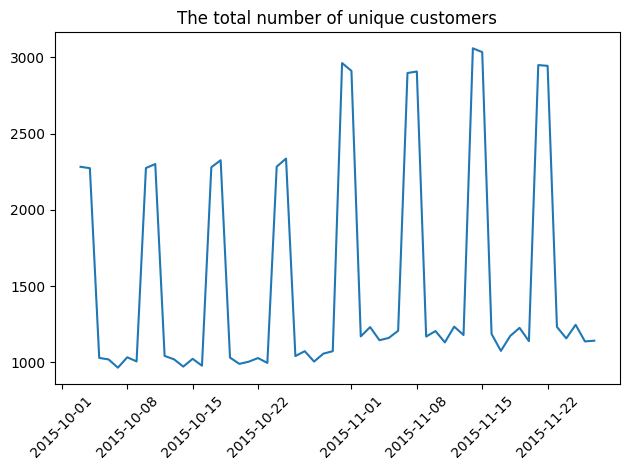

In [13]:
#Q: Can you estimate the impact the program had on the site?
#check avg number of users per day before and after the program launch
plt.title('The total number of unique customers')
plt.xticks(rotation=45)
plt.plot(data.groupby('date')['user_id'].nunique())
plt.show()


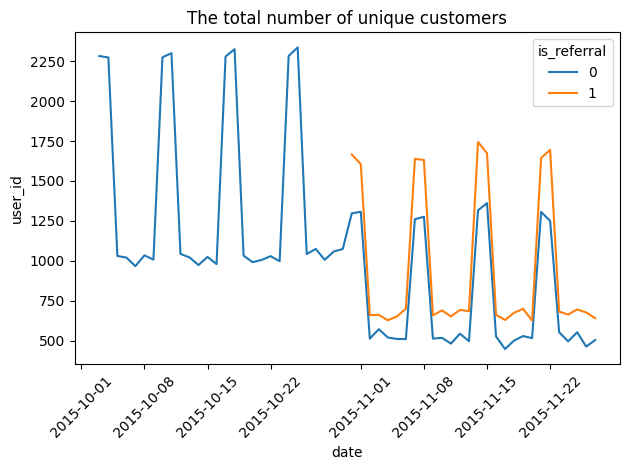

In [14]:
#Let’s now break it down by referred and non-referred users:
plt.title('The total number of unique customers')
sns.lineplot(data=data.groupby(['is_referral','date'])['user_id'].nunique().reset_index(), x='date', y='user_id', hue='is_referral')
plt.xticks(rotation=45)
plt.show()

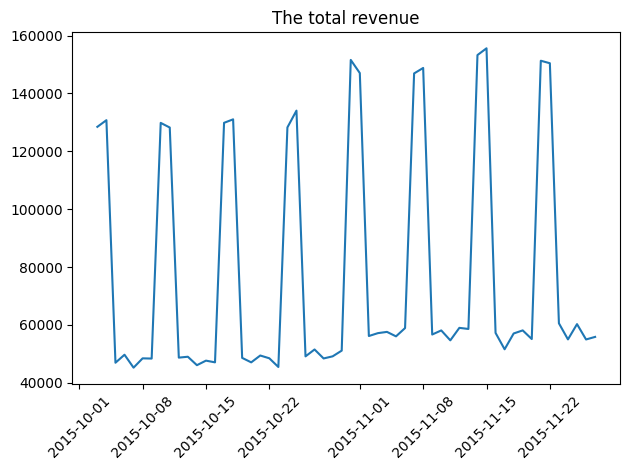

In [15]:
#Let’s check total revenue by day. This is after all the main goal of the program.
plt.title('The total revenue')
plt.xticks(rotation=45)
plt.plot(data.groupby('date')['money_spent'].sum())
plt.show()


In [16]:
#avg percenct increase of revenue and users after the change
print(pd.DataFrame({
                   "metric" : ["revenue", "users"],
               "pct_change" : [100*(data.query("date>\"2015-10-30\"").groupby('date')['money_spent'].sum().mean()/data.query("date<\"2015-10-31\"").groupby('date')['money_spent'].sum().mean()-1),
                               100*(data.query("date>\"2015-10-30\"").groupby('date')['user_id'].nunique().mean()/data.query("date<\"2015-10-31\"").groupby('date')['user_id'].nunique().mean()-1)
               ]
           })
           )


    metric  pct_change
0  revenue   16.826539
1    users   21.849607


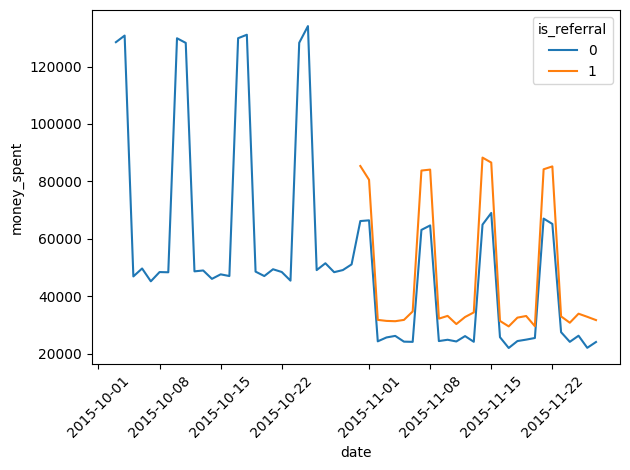

In [18]:
#Let’s break it down by people who were referred and people who were not.
data_plot = data.groupby(['date', 'is_referral'])['money_spent'].sum().reset_index()
sns.lineplot(data=data_plot, x='date', y='money_spent', hue='is_referral')
plt.xticks(rotation=45)
plt.show()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

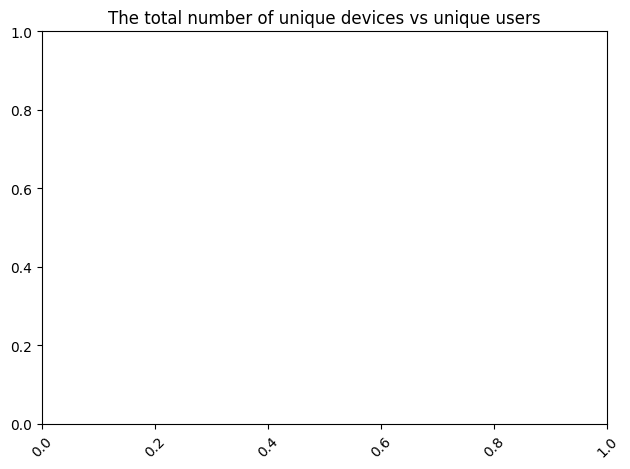

In [19]:
#check avg number of users per day before and after the program launch
plt.title('The total number of unique devices vs unique users')
plt.xticks(rotation=45)


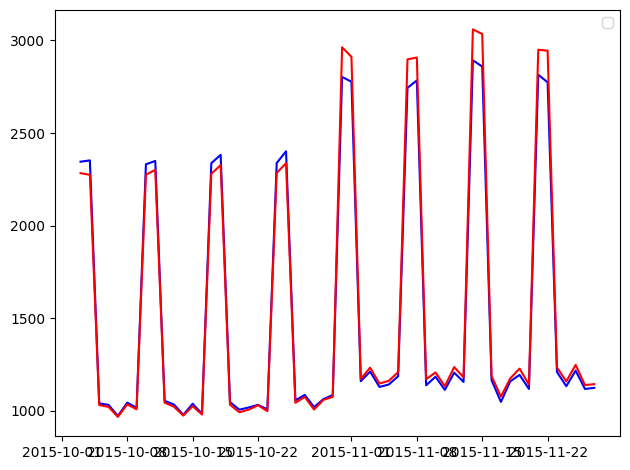

In [20]:
plt.plot(data.groupby('date')['device_id'].nunique(), color='blue')
plt.plot(data.groupby('date')['user_id'].nunique(), color='red')
plt.legend()
plt.show()


In [43]:
#load time series library prophet, we'll use it for the prediction
from prophet import Prophet

#prepare the before the change dataset. We use total transaction value as main metric
data_prediction = data.query('date<\'2015-10-31\'').groupby('date')['money_spent'].sum().reset_index()
#change column names and index
data_prediction['ds'] = data_prediction['date']
data_prediction.rename({'money_spent': 'y'}, axis=1, inplace=True)
data_prediction.set_index('date', inplace=True)

#Let's build the model using prophet. From previous plots, time series appear pretty straightforward and flattish. Default values should do fine
ts = Prophet(interval_width=0.95)
ts.fit(data_prediction)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmes3medi/v5vtjtw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmes3medi/eed4bmfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69359', 'data', 'file=/tmp/tmpmes3medi/v5vtjtw_.json', 'init=/tmp/tmpmes3medi/eed4bmfn.json', 'output', 'file=/tmp/tmpmes3medi/prophet_modelwgo8lcl_/prophet_model-20240823210141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [44]:
#make predictions until the max date we have in our dataset
days_predictions = (data['date'].max()-data_prediction['ds'].max()).days
future_data = ts.make_future_dataframe(periods = days_predictions)
predictions = ts.predict(future_data)


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


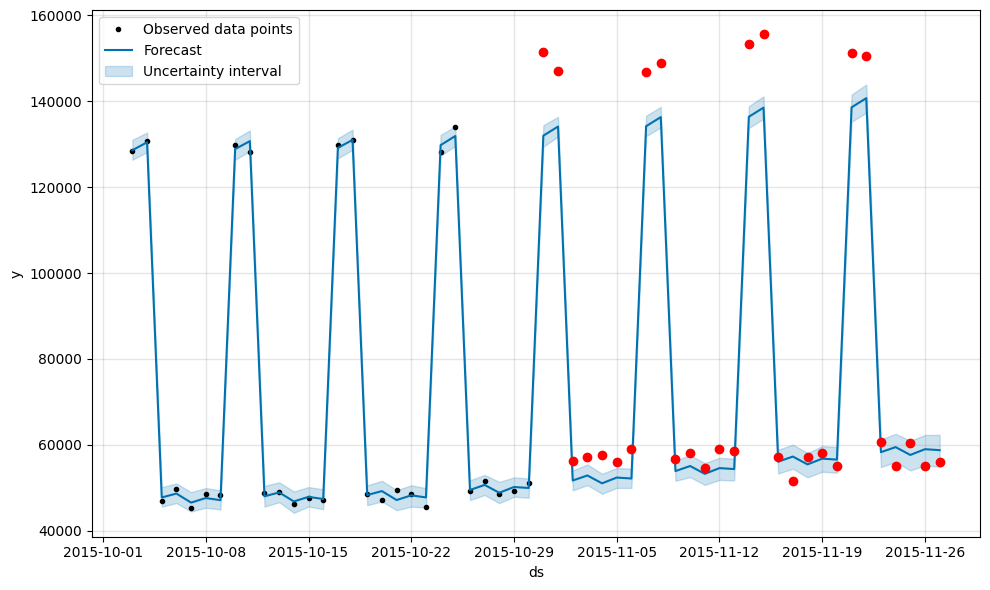

In [45]:
#let's plot them
ts.plot(predictions)
plt.plot(data.query('date>\'2015-10-30\'').groupby('date')['money_spent'].sum(), 'o', color='red')
plt.legend()
plt.show()


In [46]:
#compare the means
print("Mean revenue per day after the launch is: ", round(data.query('date>\'2015-10-30\'').groupby('date')['money_spent'].sum().mean()),
"\n",
"Mean revenue of our predictions is:",
round(predictions.query('ds>\'2015-10-30\'')['yhat'].mean())
)


Mean revenue per day after the launch is:  83714 
 Mean revenue of our predictions is: 78461


In [47]:
#Let's do a paired t-test here where we are comparing day by day
test = stats.ttest_rel(data.query('date>\'2015-10-30\'').groupby('date')['money_spent'].sum(), predictions.query('ds>\'2015-10-30\'')['yhat'])
print(round(test.pvalue,5))


0.00032
